AUTHOR: SPARSHSAH

In [1]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# annualized stats, roughly those of a dev-market country-level equity index
SHARPE = 0.5
VOL = 0.20
# make them daily
DAYCOUNT = 250
SHARPE /= DAYCOUNT**0.5
VOL /= DAYCOUNT**0.5

# how far back we want to go to calculate drawdowns
LOOKBACK = 10 * DAYCOUNT  # a decade

# simulation length
T = 100 * DAYCOUNT  # a century

In [3]:
np.random.seed(42)

# log returns
r = pd.Series(stats.norm.rvs(loc=SHARPE*VOL, scale=VOL, size=T))
# log cum returns ("price index")
px = r.cumsum()
# combine
df = pd.DataFrame({
    "CumRets": px,
    # historical peaks (we focus on rolling in this exercise)
    "RollingPeak": px.rolling(window=LOOKBACK, min_periods=0).max(),
    "ExpandingPeak": px.expanding().max()
}, columns=["CumRets", "RollingPeak", "ExpandingPeak"])

# drawdown level
dd = df["CumRets"] - df["RollingPeak"]

# was the peak achieved today?
peak_achieved = dd.abs() < 1e-6
# timestamp of most recent peak
peak_t = peak_achieved[peak_achieved].index
peak_t = pd.Series(peak_t, index=peak_t)
peak_t = peak_t.reindex(index=peak_achieved.index).ffill()
# days since most recent peak
days_since_peak = peak_t.index - peak_t

# "STD event" of this size drawdown, relative to how long it took
vol_scaled_to_days_since_last_peak = VOL * days_since_peak**0.5
dd_std = dd / vol_scaled_to_days_since_last_peak

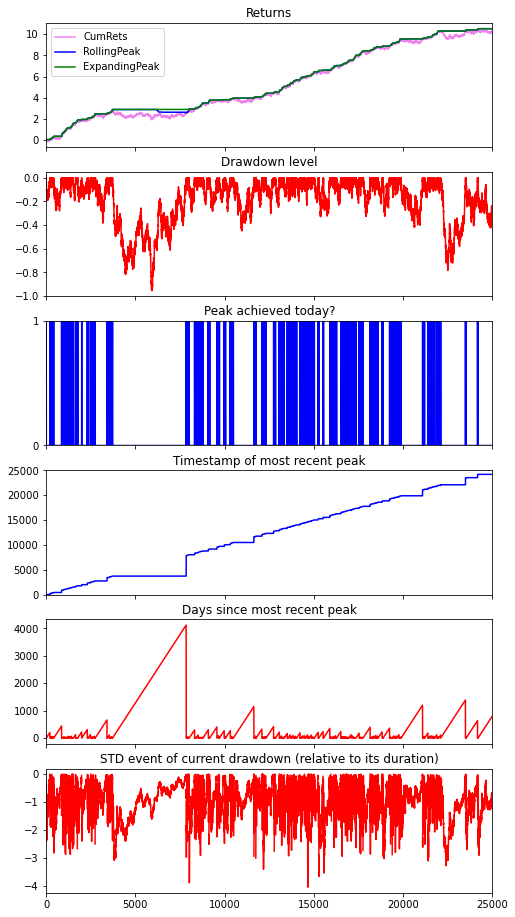

In [4]:
_, ax = plt.subplots(nrows=6, sharex=True, figsize=(8,16))

df.plot(color=["violet", "blue", "green"], xlim=(0,T),
        title="Returns", ax=ax[0])

dd.plot(c="red", xlim=(0,T), title="Drawdown level", ax=ax[1])

peak_achieved.astype(int).plot(c="blue",
                               xlim=(0,T), yticks=[0,1], ylim=(0,1),
                               title="Peak achieved today?",
                               ax=ax[2])

peak_t.plot(c="blue", xlim=(0,T), ylim=(0,T),
            title="Timestamp of most recent peak", ax=ax[3])

days_since_peak.plot(c="red", xlim=(0,T), title="Days since most recent peak",
                     ax=ax[4])

dd_std.plot(c="red", xlim=(0,T),
            title="STD event of current drawdown (relative to its duration)",
            ax=ax[5])

plt.show()